In [1]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from barnacle import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from barnacle.tensors import SparseCPTensor

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [2]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# collect and organize data

In [4]:
# data structures

# parameters
ref_boots = np.arange(100)
comp_boots= np.arange(10)
replicates = ['A', 'B', 'C']
datapath = Path('../models/')
outdir = Path('../figures/v2-batch-t=0.01/')

ranks = {
    'pro': {
        'ref': 20, 
        'comp': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    }, 
    'syn': {
        'ref': 15, 
        'comp': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    }
}
lambdas = {
    'pro': 16., 
    'syn': 16.
}

# set up data structure to store sample name data
samplenames = {
    'pro' : {
        rep: [] for rep in replicates
    },
    'syn' : {
        rep: [] for rep in replicates
    }
}

# set up data structures to store cp tensors
cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}
aligned_cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}


In [5]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
for cyano in ['pro', 'syn']: 
    for rep in replicates:
        for boot in ref_boots:
            filepath = datapath / '{}/bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(
                cyano, boot, rep, rep
            )
            ds = xr.open_dataset(filepath)
            samplenames[cyano][rep].append(ds.samplename.data)

    # compile set of samplenames common to all bootstrap / replicate splits
    samplenames[cyano]['common'] = reduce(
        np.intersect1d, 
        itertools.chain.from_iterable([samplenames[cyano][r] for r in replicates])
    )

# import one shuffled tensor dataset for reference
pro_ds = xr.open_dataset(datapath / 'pro/bootstrap0/dataset_bootstrap_0.nc')
syn_ds = xr.open_dataset(datapath / 'syn/bootstrap0/dataset_bootstrap_0.nc')

syn_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...
Attributes:
    shuffle_seed:  1336149668

In [6]:
# import all fitted models, and subset them to just the common samplenames

for cyano in ['pro', 'syn']:
    for rep in replicates:
        for rank in ranks[cyano]['comp']:
            # initialize list of cp tensors for each rank
            cps[cyano][rep][rank] = []
            aligned_cps[cyano][rep][rank] = []
            for boot in ref_boots:
                if boot in comp_boots or rank == ranks[cyano]['ref']:
                    # put together data path
                    path_cp = '{}/bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
                        cyano, boot, rep, rank, lambdas[cyano]
                    )
                else:
                    continue
                # store normalized cp tensor to cps
                cp = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
                cps[cyano][rep][rank].append(cp)
                # pull out common samplenames and store in aligned_cps
                idx = np.where(np.isin(samplenames[cyano][rep][boot], samplenames[cyano]['common']))[0]
                aligned_cps[cyano][rep][rank].append(
                    subset_cp_tensor(cp, {2: idx})
                )
            
aligned_cps['syn']['A'][10][0]


(weights, factors) : rank-10 CPTensor of shape (6161, 6, 55)

# compare aligned components
- choose best representative reference cp tensor
    - reference rank
    - choose based on best overall mean FMS agains all other cp tensors
- sort reference tensor components in order of variance explained
- align all other tensors to sorted reference tensor (using None-type tensors to fill gaps)
- calculate FMS between each pair of aligned components (comparison vs. reference)


In [7]:
# find best representative reference cp tensor for each genus

results = []
for cyano, ref_rep, ref_boot in list(itertools.product(['pro', 'syn'], replicates, ref_boots)):
    ref_rank = ranks[cyano]['ref']
    reference_cp = aligned_cps[cyano][ref_rep][ref_rank][ref_boot]
#     for comp_rep, comp_rank, comp_boot in list(itertools.product(replicates, ranks[cyano]['comp'], comp_boots)):
    for comp_rep, comp_boot in list(itertools.product(replicates, ref_boots)):
        comp_rank = ranks[cyano]['ref']
        # no point in comparing to self
        if ref_rep == comp_rep and ref_rank == comp_rank and ref_boot == comp_boot:
            continue
        comparison_cp = aligned_cps[cyano][comp_rep][comp_rank][comp_boot]
        fms = factor_match_score(
            reference_cp, 
            comparison_cp, 
            consider_weights=False
        )
        results.append({
            'genus': cyano, 
            'reference_rank': ref_rank, 
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'comparison_rank': comp_rank, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'fms': fms, 
        })
        
fms_df = pd.DataFrame(results)

# summarize overall mean fms
best_rep_df = fms_df.groupby([
    'genus', 
#     'comparison_rank', 
    'reference_rank', 
    'reference_bootstrap', 
    'reference_replicate'
]).agg(
    mean_fms=('fms', 'mean'), 
    boot_count=('fms', 'count')
).reset_index()
# find the top mean for each comparison rank
# best_rep_df = best_rep_df.sort_values(['genus', 'mean_fms'], ascending=False)
best_rep_df = best_rep_df.iloc[best_rep_df.groupby([
    'genus', 
#     'comparison_rank'
]).mean_fms.idxmax().values, :]

best_rep_df


,genus,reference_rank,reference_bootstrap,reference_replicate,mean_fms,boot_count
93,pro,20,31,A,0.653508,299
423,syn,15,41,A,0.640135,299


In [8]:
# collect aligned component comparison data

results = []
for cyano in ['pro', 'syn']:
    # pull out reference cp
    specs = best_rep_df[best_rep_df['genus'] == cyano].to_dict('records')[0]
    ref_rep = specs['reference_replicate']
    ref_rank = specs['reference_rank']
    ref_boot = specs['reference_bootstrap']
    # sort reference cp factors in order of explained variance
    reference_cp = tlviz.factor_tools.permute_cp_tensor(
        aligned_cps[cyano][ref_rep][ref_rank][ref_boot], 
        consider_weights=True
    ) 
    aligned_cps[cyano][ref_rep][ref_rank][ref_boot] = reference_cp
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_rank, comp_boot in list(itertools.product(replicates, ranks[cyano]['comp'], ref_boots)):
        if comp_boot not in comp_boots and ref_rank != comp_rank:
            continue    # only look at bootstraps beyond comparison bootstraps if they are reference rank
        elif ref_rep == comp_rep and ref_rank == comp_rank and ref_boot == comp_boot:
            continue    # no point in comparing to self
        # re-align comparison cp to the reference cp
        comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_cps[cyano][comp_rep][comp_rank][comp_boot], 
            reference_cp_tensor=reference_cp, 
            consider_weights=False, 
            allow_smaller_rank=True
        )
        aligned_cps[cyano][comp_rep][comp_rank][comp_boot] = comparison_cp
        # compare each aligned component
        for i, comp_component in enumerate(SparseCPTensor(comparison_cp).get_components()):
            # skip the None-type components included for aligning smaller cp tensors
            if np.all(np.isnan(comp_component.factors[0])):
                continue
            # compare components
            fms = factor_match_score(
                comp_component, 
                ref_components[i], 
                consider_weights=False,
            )
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'reference_component': i, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_rank': comp_rank, 
                'comparison_component': i, 
                'fms': fms 
            })
            
component_df = pd.DataFrame(results)
component_df


,genus,reference_bootstrap,reference_replicate,reference_rank,reference_component,comparison_bootstrap,comparison_replicate,comparison_rank,comparison_component,fms
0,pro,31,A,20,16,0,A,1,16,0.639635
1,pro,31,A,20,16,1,A,1,16,0.618034
2,pro,31,A,20,16,2,A,1,16,0.672834
3,pro,31,A,20,16,3,A,1,16,0.713780
4,pro,31,A,20,8,4,A,1,8,0.565690
...,...,...,...,...,...,...,...,...,...,...
19310,syn,41,A,15,10,99,C,15,10,0.917146
19311,syn,41,A,15,11,99,C,15,11,0.697063
19312,syn,41,A,15,12,99,C,15,12,0.000000
19313,syn,41,A,15,13,99,C,15,13,0.716885


In [9]:
# calculate variation explained by the best representative cp tensor for each bootstrapped dataset

results = []
for cyano in ['pro', 'syn']:
    # pull out best representative cp tensor
    specs = best_rep_df[best_rep_df['genus'] == cyano].to_dict('records')[0]
    ref_rep = specs['reference_replicate']
    ref_rank = specs['reference_rank']
    ref_boot = specs['reference_bootstrap']
    # get reference cp (down-selected to just common samples)
    reference_cp = aligned_cps[cyano][ref_rep][ref_rank][ref_boot]
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_boot in list(itertools.product(replicates, ref_boots)):
        # no point in comparing to self
        if ref_rep == comp_rep and ref_boot == comp_boot:
            continue
        # get shuffled tensor data for each bootstrap
        filepath = '{}/bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(
            cyano, comp_boot, comp_rep, comp_rep
        )
        reference_ds = xr.open_dataset(datapath / filepath)
        # pull out just the data corresponding to common sample indices
        reference_tensor = reference_ds.sel(samplename=samplenames[cyano]['common']).residual.data
        # calculate variance captured by each factor
        explained_vars = tlviz.factor_tools.percentage_variation(
            reference_cp, 
            dataset=reference_tensor, 
            method='data'
        )
        # calculate fit of each component
        for i, component in enumerate(ref_components):
            fit = tlviz.model_evaluation.fit(component, reference_tensor)
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_component': i, 
                'explained_variation': explained_vars[i], 
                'component_fit': fit 
            })

var_df = pd.DataFrame(results)
var_df


,genus,reference_bootstrap,reference_replicate,reference_rank,comparison_bootstrap,comparison_replicate,comparison_component,explained_variation,component_fit
0,pro,31,A,20,0,A,0,2.435626,-0.007444
1,pro,31,A,20,0,A,1,2.004596,0.063017
2,pro,31,A,20,0,A,2,1.000285,0.020171
3,pro,31,A,20,0,A,3,0.859943,0.017424
4,pro,31,A,20,0,A,4,0.673185,0.003420
...,...,...,...,...,...,...,...,...,...
10460,syn,41,A,15,99,C,10,0.304330,0.007527
10461,syn,41,A,15,99,C,11,0.203743,0.004319
10462,syn,41,A,15,99,C,12,0.124724,0.003695
10463,syn,41,A,15,99,C,13,0.077736,0.001857


# plot component robustness

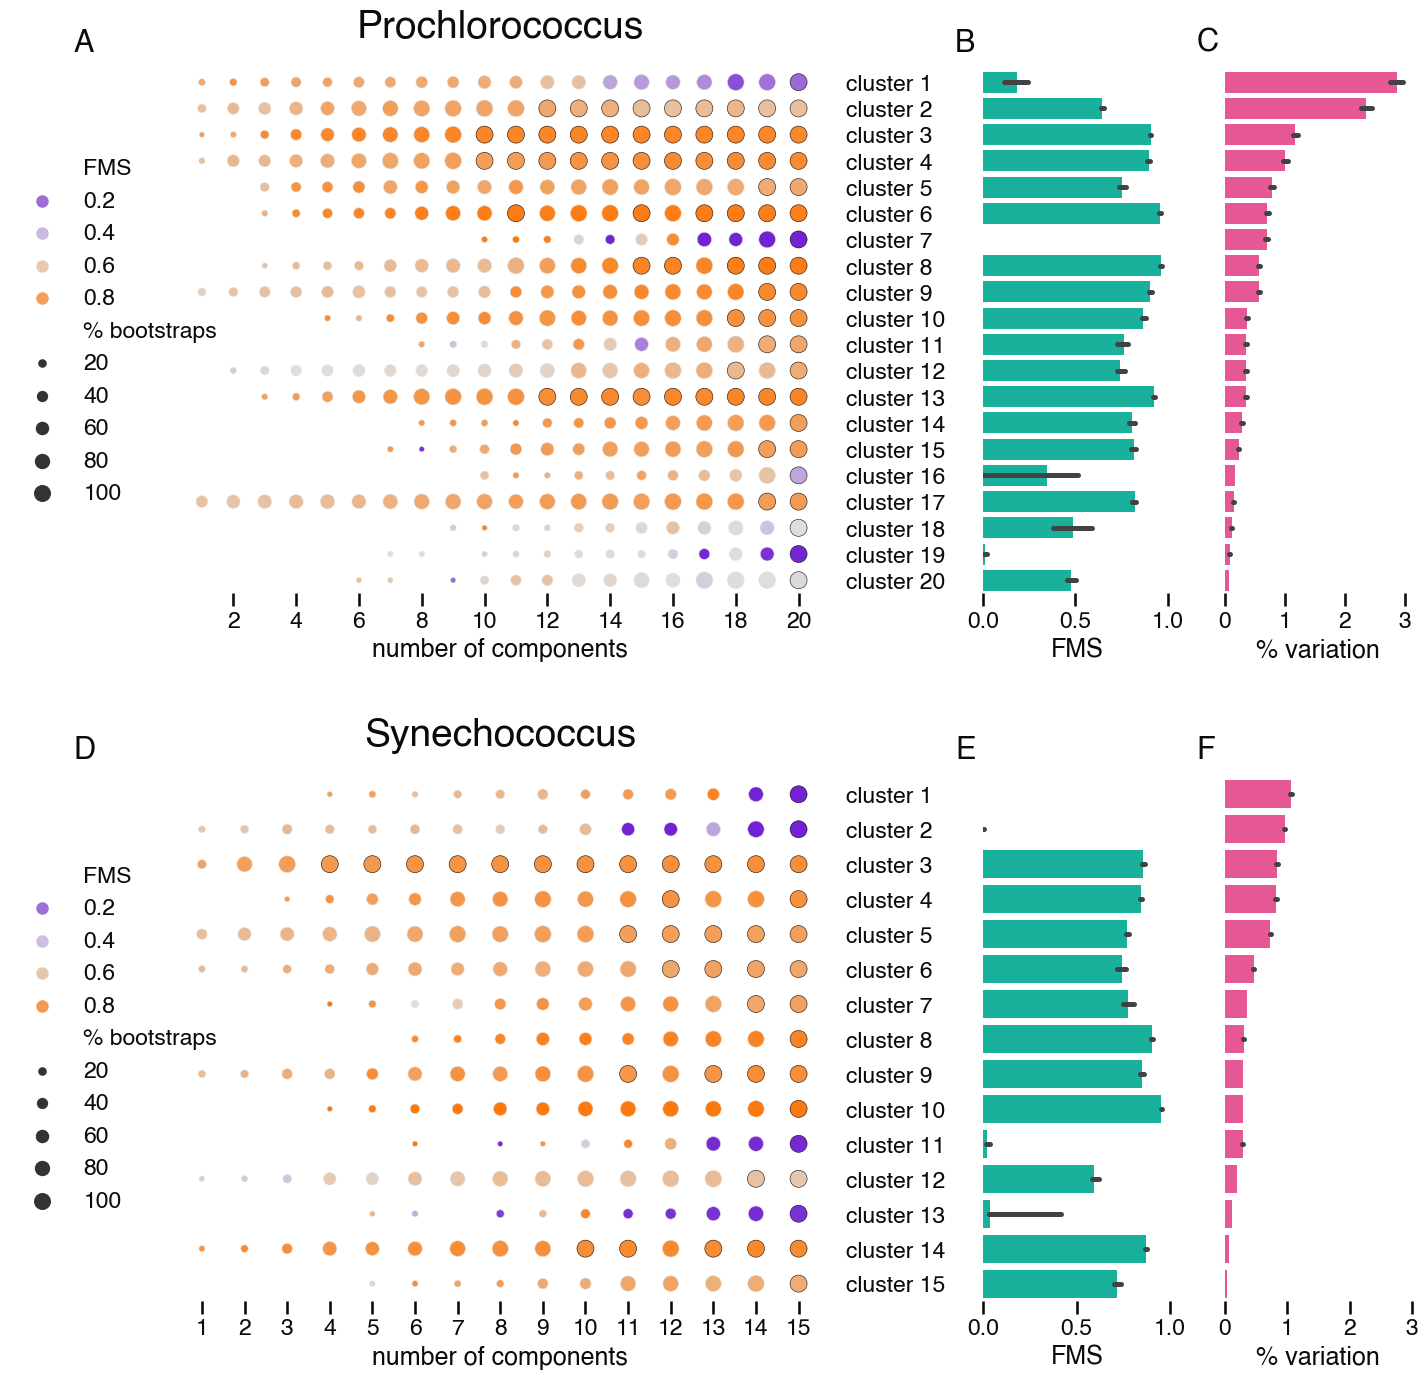

In [10]:
# component robustness plot

# make multiple plots sub
fig, axes = plt.subplots(
    2, 4, figsize=(16, 16), sharey='row', width_ratios=(7, .5, 2, 2), gridspec_kw={'hspace': 0.35}
)
annotations = {0: 'A', 2: 'B', 3: 'C', 4: 'D', 6: 'E', 7: 'F'}
annot_kws = dict(
    xy=(-0.15, 1.05), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=22, annotation_clip=False
)

for row, cyano in enumerate(['pro', 'syn']):

    # set up component robustness dataframe
    df = component_df[component_df['genus'] == cyano]
    df = df.groupby(['comparison_rank', 'reference_component']).agg(
        FMS = ('fms', 'median'), 
        bootstrap_count = ('fms', 'count')
    ).reset_index()
    # calculate bootstrap percentage
    df['total_bootstraps'] = len(comp_boots) * 3
    df.loc[df['comparison_rank'] == ranks[cyano]['ref'], 'total_bootstraps'] = (len(ref_boots) * 3) - 1
    df['% bootstraps'] = df['bootstrap_count'] / df['total_bootstraps'] * 100
    df['all bootstraps'] = df['% bootstraps'] == 100

    # set up component dataframe
    comp_stats_df = component_df[
        (component_df['genus'] == cyano) & 
        (component_df['comparison_rank'] == ranks[cyano]['ref'])
    ]

    # plot robustness patterns
    i = 0
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    axes[row][i].annotate(
        {0: 'Prochlorococcus', 1: 'Synechococcus'}[row], xy=(0.5, 1.08), xycoords='axes fraction', 
        va='center', ha='center', weight='bold', style='italic', fontsize=28, annotation_clip=False
    )
    marker_palette = {True: line_color, False: neutral_color}
    sns.scatterplot(
        x='comparison_rank', 
        y='reference_component', 
        hue='FMS', 
        size='% bootstraps', 
        sizes=(15, 150), 
        edgecolor=df['all bootstraps'].map(marker_palette), 
        palette=div_cmap, 
        data=df, 
        legend='brief',
        ax=axes[row][i]
    ); 
    axes[row][i].legend(loc='center right', alignment='right', bbox_to_anchor=(0.1, 0.5));
    if cyano == 'pro':
        axes[row][i].set(xlabel='number of components', xticks=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20], ylabel=None)
    elif cyano == 'syn':
        axes[row][i].set(xlabel='number of components', xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
                         ylabel=None)

    # skip axis for label space
    i = 1
    axes[row][i].tick_params(left=False, bottom=False, labelbottom=False)

    # plot component fms
    i = 2
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    sns.barplot(
        data=comp_stats_df, 
        x='fms', 
        y='comparison_component', 
        estimator='median', 
#         errorbar=None, 
        orient='h', 
        color=sns.color_palette()[2], 
        ax=axes[row][i]
    ); 
    axes[row][i].set(xlabel='FMS', xticks=[0, .5, 1], ylabel=None);
    axes[row][i].tick_params(left=False)

    # plot % variance explained
    i = 3
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    sns.barplot(
        data=var_df[var_df['genus'] == cyano], 
        x='explained_variation', 
        y='comparison_component', 
        estimator='median', 
#         errorbar=None, 
        orient='h', 
        color=sns.color_palette()[3], 
        ax=axes[row][i]
    ); 
    axes[row][i].tick_params(left=False)
    axes[row][i].set(xlabel='% variation', xticks=[0, 1, 2, 3], ylabel=None)
#     if cyano == 'pro':
#         axes[row][i].set(xlabel='% variation', xticks=[0, 1, 2, 3], ylabel=None)
#     elif cyano == 'syn':
#         axes[row][i].set(xlabel='% variation', xticks=[0, 0.5, 1.0, 1.5], ylabel=None)

    # set cluster labels
    axes[row][0].tick_params(left=False, right=False, labelleft=False, labelright=True)
    if cyano == 'pro':
        axes[row][0].set_yticks(np.arange(20), [f'cluster {i+1}' for i in np.arange(20)]);
    elif cyano == 'syn':
        axes[row][0].set_yticks(np.arange(15), [f'cluster {i+1}' for i in np.arange(15)]);

plt.savefig(outdir / 'component-robustness.png', bbox_inches='tight')


# List clusters by median FMS

In [11]:
# make comp_stats_df

comp_stats_df = pd.DataFrame()
for cyano in ['pro', 'syn']: 
    df = component_df[
        (component_df['genus'] == cyano) & 
        (component_df['comparison_rank'] == ranks[cyano]['ref'])
    ]
    if len(comp_stats_df) == 0:
        comp_stats_df = df
    else: 
        comp_stats_df = pd.concat([comp_stats_df, df])
        
# join explained variance
comp_stats_df = pd.merge(
    left=comp_stats_df, 
    right=var_df[['genus', 'comparison_bootstrap', 'comparison_replicate', 
                  'comparison_component', 'explained_variation']], 
    on=['genus', 'comparison_bootstrap', 'comparison_replicate', 'comparison_component']
)
comp_stats_df['cluster'] = comp_stats_df['comparison_component'] + 1

comp_stats_df.groupby(['genus', 'cluster']).median(
    ['fms', 'explained_variation']).reset_index().sort_values(
    ['genus', 'fms'], ascending=False
)


,genus,cluster,reference_bootstrap,reference_rank,reference_component,comparison_bootstrap,comparison_rank,comparison_component,fms,explained_variation
29,syn,10,41.0,15.0,9.0,50.0,15.0,9.0,0.953203,0.293636
27,syn,8,41.0,15.0,7.0,50.0,15.0,7.0,0.902722,0.304913
33,syn,14,41.0,15.0,13.0,50.0,15.0,13.0,0.867917,0.074285
22,syn,3,41.0,15.0,2.0,50.0,15.0,2.0,0.855211,0.841073
28,syn,9,41.0,15.0,8.0,50.0,15.0,8.0,0.849459,0.293952
23,syn,4,41.0,15.0,3.0,50.0,15.0,3.0,0.842974,0.826420
26,syn,7,41.0,15.0,6.0,50.0,15.0,6.0,0.772829,0.362740
24,syn,5,41.0,15.0,4.0,50.0,15.0,4.0,0.771246,0.730516
25,syn,6,41.0,15.0,5.0,50.0,15.0,5.0,0.740063,0.464371
34,syn,15,41.0,15.0,14.0,50.0,15.0,14.0,0.714968,0.032530


In [12]:
# print Prochlorococcus data

pro_comp_df = comp_stats_df[comp_stats_df['genus'] == 'pro']
pro_comp_df = pro_comp_df.groupby('cluster').median(
    ['fms', 'explained_variation']).reset_index().sort_values(
    'fms', ascending=False
)
cluster_list = pro_comp_df[pro_comp_df['fms'].gt(0.5)]['cluster'].to_list()
print(cluster_list)
print(len(cluster_list))

pro_comp_df[['cluster', 'fms', 'explained_variation']]


[8, 6, 13, 3, 9, 4, 10, 17, 15, 14, 11, 5, 12, 2]
14


,cluster,fms,explained_variation
7,8,0.962059,0.580431
5,6,0.955683,0.712835
12,13,0.926489,0.354187
2,3,0.907319,1.175456
8,9,0.905161,0.571164
3,4,0.896061,1.010538
9,10,0.868413,0.377891
16,17,0.821877,0.153393
14,15,0.815766,0.233748
13,14,0.808628,0.287570


In [13]:
# print Synechococcus data

syn_comp_df = comp_stats_df[comp_stats_df['genus'] == 'syn']
syn_comp_df = syn_comp_df.groupby('cluster').median(
    ['fms', 'explained_variation']).reset_index().sort_values(
    'fms', ascending=False
)
cluster_list = syn_comp_df[syn_comp_df['fms'].gt(0.5)]['cluster'].to_list()
print(cluster_list)
print(len(cluster_list))

syn_comp_df[['cluster', 'fms', 'explained_variation']]


[10, 8, 14, 3, 9, 4, 7, 5, 6, 15, 12]
11


,cluster,fms,explained_variation
9,10,0.953203,0.293636
7,8,0.902722,0.304913
13,14,0.867917,0.074285
2,3,0.855211,0.841073
8,9,0.849459,0.293952
3,4,0.842974,0.826420
6,7,0.772829,0.362740
4,5,0.771246,0.730516
5,6,0.740063,0.464371
14,15,0.714968,0.032530
